In [34]:
import librosa
from matplotlib import pyplot as plt
fname = "../webcache/https__/samples.grbt.com.au/br160/ADAMSP~1.WAV"
samples, _ = librosa.load(fname, sr=48000, mono=True)
from IPython.display import Audio
Audio(samples, rate=48000)

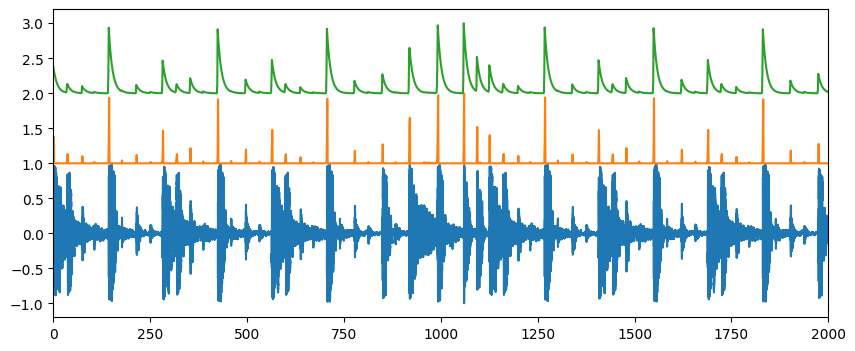

In [81]:
import numpy as np
def magsq(x): return x * np.conj(x)
n_fft = 512
hop_length = 128
window = np.hanning(n_fft)
stft = librosa.stft(
    samples, 
    n_fft=n_fft, 
    hop_length=hop_length, 
    window=window, 
    center=True
)
fluxes=[]
freqs=np.arange(n_fft//2+1)+0.5
mag=magsq(stft) * freqs[:, None] # pink noise weighting
padded_mag=np.concatenate(
    [np.zeros((mag.shape[0], 2), mag.dtype), mag], axis=1
)
# try complex prediction rather than flux.
# padded_stft = np.concatenate(
#     [np.zeros((stft.shape[0], 2), stft.dtype), stft], axis=1
# )
# prevprev = padded_stft[:, :-2]  # (bins, frames)
# prev = padded_stft[:, 1:-1]
# curr = padded_stft[:, 2:]
# delta = np.where(np.abs(prevprev) > 0.00001, prev / prevprev, 0)
# delta /= np.maximum(np.abs(delta), 1)
# pred = prev * delta
# flux = np.abs(pred - curr) ** 2  # (bins, frames)
prev = padded_mag[:, 1:-1]
curr = padded_mag[:, 2:]
flux=np.maximum(curr-prev,0)
flux = flux.mean(axis=0)  # mean over bins, shape (frames,)
emaflux=flux[0]
emafluxes=[]
for i in range(1,len(flux)):
    if flux[i] > emaflux:
        emaflux = flux[i]
    else:
        emaflux = 0.9 * emaflux
        flux[i] = max(0,flux[i]-emaflux)
    emafluxes.append(emaflux)
emafluxes=np.array(emafluxes)
peakflux=flux.max()
samplesx = np.arange(len(samples))/128
plt.figure(figsize=(10,4))
plt.xlim(0, 2000)
plt.plot(samplesx,samples)
plt.plot(flux/peakflux+1)
plt.plot(emafluxes/peakflux+2)
plt.show()


/Users/alexe/dev/ginkgo/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/alexe/dev/ginkgo/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


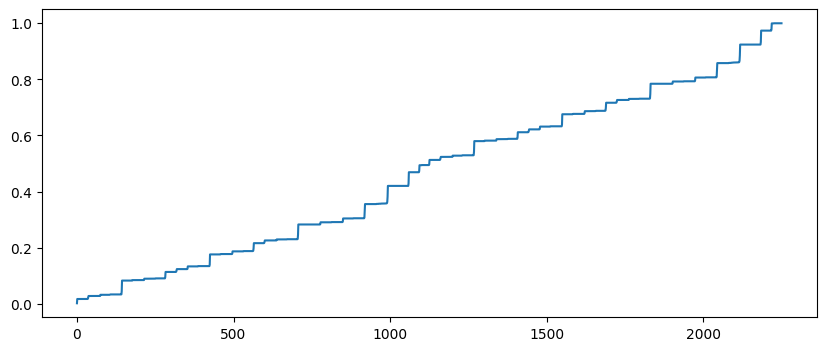

In [79]:
cdf=np.cumsum(flux)
plt.figure(figsize=(10,4))
plt.plot(cdf/cdf.max())
plt.show()